# 6. Full-Dataset Inference & Agreement Analysis


**From Theory to Full-Scale Prediction — A Critical Milestone**

In the [previous notebook](https://github.com/alikhalajii/text-classification-life-sciences/blob/master/notebooks/05-training-embedding-models.ipynb), we built the core classifiers that power our inference engine: each trained on clean, labeled slices of app descriptions. Now, we shift gears. We ask the real-world question: _What happens when we unleash these models on **everything**?_

Welcome to Notebook 6, where abstraction meets reality.

Here, we apply our trio of text-only models (Word2vec, fastText, SBERT) across all 14,000+ unlabeled app descriptions. It's not just a stress test — it's an opportunity to study behavior at scale, pinpoint model agreement zones, and diagnose weaknesses that only emerge in full deployment.

By fusing their predictions via a **majority vote**, we create a more balanced, resilient classifier. Think of it less as a final decision-maker and more as a smart filter — helping us triage what's clearly relevant and what deserves human attention.

This is more than just prediction; it’s an exploration of model synergy, domain drift, and hidden ambiguity. It's about pushing your pipeline into the wild while keeping a sharp, journalistic eye on what it gets right, where it stumbles, and how we use that to improve.

Now let’s get analytic.


## 6.1 Predicting Relevance on the Full Dataset


In [2]:
%matplotlib inline
from IPython.display import display

from pathlib import Path
BASE_DIR = Path.cwd().parent


In [3]:
import os
import re
import joblib
import string
from tqdm import tqdm

import numpy as np
import pandas as pd

from gensim.models import Word2Vec, FastText
from sentence_transformers import SentenceTransformer

# Load dataset
df_cleaned = pd.read_csv(BASE_DIR / "data/02_df_cleaned_all_text.csv", encoding='utf-8')
texts_all = df_cleaned["all_text"].astype(str)

# Tokenizer for W2V / FT
def simple_tokenizer(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    return text.split()

tokens_all = texts_all.apply(simple_tokenizer)

# Function to compute doc vectors (W2V / FT)
def get_doc_vectors(tokens, model, vec_size):
    return np.vstack([
        np.mean([model.wv[w] for w in toks if w in model.wv] or [np.zeros(vec_size)], axis=0)
        for toks in tqdm(tokens, desc="Embedding docs")
    ])

# === Embedding-based Models Only ===
MODELS = [
    {"name": "Word2Vec + LR", "embed": True, "vec_path": BASE_DIR / "checkpoints/word2vec_model.gensim",  "clf_path": BASE_DIR / "checkpoints/word2vec_lr.pkl",  "vector_size": 100},
    {"name": "FastText + LR", "embed": True, "vec_path": BASE_DIR / "checkpoints/fasttext_model.gensim",  "clf_path": BASE_DIR / "checkpoints/fasttext_lr.pkl",  "vector_size": 100},
    {"name": "SBERT + LR",    "embed": False,"clf_path": BASE_DIR / "checkpoints/sbert_lr.pkl"},
]

# Run predictions
results = {}
for model in MODELS:
    print(f"\n==== Running {model['name']} ====")
    clf = joblib.load(model["clf_path"])

    if model["embed"]:
        # W2V or FastText
        vec_path = str(model["vec_path"])  # Ensure it's a string
        vec_model = Word2Vec.load(vec_path) if "word2vec" in vec_path else FastText.load(vec_path)
        X = get_doc_vectors(tokens_all, vec_model, model["vector_size"])
    else:
        # SBERT: use cached embeddings
        sbert_path = BASE_DIR / "checkpoints/sbert_embeddings_full.npy"
        if os.path.exists(sbert_path):
            print("📦 Loading cached SBERT embeddings...")
            X = np.load(sbert_path)
        else:
            print("⚙️  Computing SBERT embeddings (may take time)...")
            sbert = SentenceTransformer("all-MiniLM-L6-v2")
            X = sbert.encode(texts_all.tolist(), show_progress_bar=True, batch_size=128)
            np.save(sbert_path, X)

    y_pred = clf.predict(X)
    results[model["name"]] = y_pred

    # Save binary label column
    col = model["name"].lower().replace(" ", "_").replace("+", "").replace("(", "").replace(")", "")
    df_cleaned[col] = y_pred.astype(int)

    print(f"✅ {model['name']} — Relevant: {sum(y_pred==1)}, Irrelevant: {sum(y_pred==0)}")

# Majority Voting
model_cols = [model["name"].lower().replace(" ", "_").replace("+", "").replace("(", "").replace(")", "")
              for model in MODELS]
df_cleaned["majority_vote"] = df_cleaned[model_cols].sum(axis=1).apply(lambda x: 1 if x >= 2 else 0)
#df_cleaned.drop(columns=["all_text"], inplace=True)

# Save final predictions
output_file = BASE_DIR / "predictions/06_final_majority_vote_predictions.csv"
df_cleaned.to_csv(output_file, index=False)
print(f"\n✅ All predictions saved to: {output_file}")



==== Running Word2Vec + LR ====


Embedding docs: 100%|██████████| 14112/14112 [00:11<00:00, 1234.81it/s]


✅ Word2Vec + LR — Relevant: 8533, Irrelevant: 5579

==== Running FastText + LR ====


Embedding docs: 100%|██████████| 14112/14112 [01:04<00:00, 217.67it/s]


✅ FastText + LR — Relevant: 8412, Irrelevant: 5700

==== Running SBERT + LR ====
📦 Loading cached SBERT embeddings...
✅ SBERT + LR — Relevant: 8727, Irrelevant: 5385

✅ All predictions saved to: /home/khalaji/Coding/text-classification-life-sciences/predictions/06_final_majority_vote_predictions.csv


With all three models deployed and their predictions consolidated, we pivot from individual relevance assessments to the collective insight offered by the `majority_vote`. This step distills conflicting judgments into a unified verdict; an ensemble voice emerging from diverse linguistic perspectives.

In [4]:
df_cleaned[:5][["fioriId", "word2vec__lr", "fasttext__lr", "sbert__lr", "majority_vote"]]

,fioriId,word2vec__lr,fasttext__lr,sbert__lr,majority_vote
0,1KE4,0,0,0,0
1,AB08,1,1,1,1
2,ABAAL,0,0,0,0
3,ABAON,1,1,1,1
4,ABAVN,1,1,1,1


## 6.2 Analysis of Model Predictions & Agreement

To explore how the models aligned or diverged in their relevance predictions, we begin with a quantitative snapshot.

### Prediction Volume per Model
This overview compares the number of samples classified as relevant and irrelevant by each of the three embedding-based models, alongside the final majority vote. The slight discrepancies between models suggest nuanced interpretive differences, yet the majority vote harmonizes their perspectives into a more stable consensus. This serves as a foundation for deeper agreement analysis in the next steps.


In [5]:
summary = pd.DataFrame({
    'Relevant':  df_cleaned[model_cols].sum(), 
    'Irrelevant': df_cleaned.shape[0] - df_cleaned[model_cols].sum()  # total minus count of 1s
})

summary['Total'] = df_cleaned.shape[0]     

display(summary.style.background_gradient(cmap='YlGnBu'))

,Relevant,Irrelevant,Total
word2vec__lr,8533,5579,14112
fasttext__lr,8412,5700,14112
sbert__lr,8727,5385,14112


* The prediction volumes across models are broadly consistent, each processing 14,112 samples. Word2Vec and FastText yield similar relevance counts 8535 and 8397 respectively, while SBERT identifies slightly more relevant documents (8727), likely due to its deeper semantic understanding.

### Model Agreement Count


In [6]:
# Prepare DataFrame for interactive display
interactive_df = df_cleaned[model_cols + ["majority_vote"]].copy()

# Compute agreement score
interactive_df["agreement"] = interactive_df[model_cols].sum(axis=1)


agreement_table = interactive_df["agreement"].value_counts().sort_index().reset_index()
agreement_table.columns = ["# Models Predicting Relevant", "Document Count"]

display(agreement_table)


,# Models Predicting Relevant,Document Count
0,0,5328
1,1,292
2,2,96
3,3,8396



* The aggreement count table confirms a stark polarization in predictions: 8380 documents were unanimously marked relevant by all three models, while 5327 were unanimously deemed irrelevant. These dominant counts indicate that the classifiers often converge with confidence. However, a small slice, 405 documents, fell into the ambiguous zone with only partial agreement (1 or 2 models predicting relevance). These edge cases may reflect subtler semantic cues or borderline content that challenges the consistency of our classifiers. Exploring these could provide valuable insights for improving ensemble precision and identifying limitations in individual embedding approaches.

### Correlation Heatmap


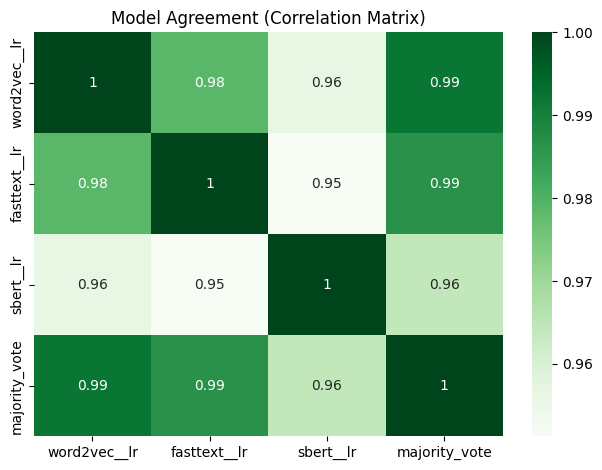

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation of predictions between models
corr = df_cleaned[model_cols + ["majority_vote"]].corr()
sns.heatmap(corr, annot=True, cmap="Greens")
plt.title("Model Agreement (Correlation Matrix)")
plt.tight_layout()
plt.savefig(BASE_DIR / "plots/model_agreement_correlation_matrix.png", dpi=150)
plt.show()


* The visualization above reveals strong predictive alignment among the models. Word2Vec and FastText exhibit near-perfect correlation (0.98), suggesting they interpret relevance similarly—likely due to their shared shallow embedding architecture. SBERT, while still highly correlated (0.95–0.96), introduces subtle semantic distinctions that slightly differentiate its predictions. The majority vote shows robust correlation with all three, confirming its role as a balanced aggregator of model perspectives.


### Model Agreement Proportion


In [10]:
import plotly.express as px

agreement_counts = interactive_df["agreement"].value_counts().sort_index()

fig = px.pie(
    names=agreement_counts.index,
    values=agreement_counts.values,
    title="Model Agreement Proportion",
    hole=0.4
)

# Make the figure smaller
fig.update_layout(
    width=400,
    height=400,
    title_font_size=16
)
fig.write_html(BASE_DIR / "reports/model_agreement_pie_chart.html")
display(fig)

* The pie chart above illustrates a clear polarization in model agreement: nearly 60% of documents were unanimously predicted as relevant, while about 38% were unanimously deemed irrelevant. ***Only a small fraction—less than 3%***, fell into partial agreement zones (1 or 2 models predicting relevance), underscoring the overall consistency among classifiers. This strong consensus reinforces ***the reliability of the majority vote*** and highlights a narrow band of ambiguity worth closer inspection.

### Text Length vs Prediction

In [9]:
interactive_df["Text Length"] = df_cleaned["all_text"].apply(len)

fig = px.box(interactive_df, x="majority_vote", y="Text Length", color="majority_vote")

display

<function IPython.core.display_functions.display(*objs, include=None, exclude=None, metadata=None, transient=None, display_id=None, raw=False, clear=False, **kwargs)>

* The box plot above reveals a notable trend: documents labeled as irrelevant by the majority vote tend to have significantly longer text lengths, with a wider spread and more extreme outliers. In contrast, relevant documents are generally shorter and more tightly distributed. This suggests that excessive length may dilute topical focus or introduce noise, making relevance harder to detect across models.

## Majority-Vote Ensemble and Model Insights

Our evaluation across three distinct embedding models—Word2Vec, FastText, and SBERT—shows over 97% agreement in classification outcomes. This high concordance validates the reliability of our text-based classifiers and supports the use of a majority-vote ensemble as a robust decision strategy.

Disagreements, limited to around 3% of cases, mark ideal targets for manual inspection or active learning, helping to systematically close annotation gaps.

SBERT, used here with minimal fine-tuning, adds semantic depth through transfer learning. Its tendency toward conservative (irrelevant) predictions balances the behavior of the simpler models, improving ensemble stability.

We also observe that longer texts are more often tagged as irrelevant, suggesting a dilution of signal in verbose narratives. This highlights future directions such as segment-based analysis or hierarchical modeling to better capture relevance cues.


# Conclusion

| Model                         | Accuracy | Precision | Recall | F1-Score |
|-------------------------------|:--------:|:---------:|:------:|:--------:|
| TF-IDF + Logistic Regression  |   0.930   |   0.978    |  **0.880**  |   0.926   |
| TF-IDF + Random Forest        |   **0.940**   |   **1**    |  **0.880**  |   **0.936**   |
| Word2Vec + Logistic Regression|   0.920   |   0.977    |  0.860  |   0.915   |
| FastText + Logistic Regression|   0.930   |   0.979    |  **0.880**  |   0.926   |
| SBERT + Logistic Regression   |   0.900   |   0.917    |  **0.880**  |   0.898  


**Wrapping Up: What We've Learned**

After a full journey through modeling experiments, the results speak clearly.

**The Best Performer**

TF‑IDF combined with Random Forest gave us the strongest performance overall. With 94% accuracy and an F1-score of 0.936, it's a solid, interpretable model that doesn't require complex tuning.

**What Other Models Showed**

- **Embedding-based methods** like Word2Vec, FastText, and SBERT also performed wellو especially FastText in recall and SBERT in semantic flexibility.  
- **TF‑IDF + Logistic Regression** was not far behind the winner, showing that classic approaches still hold value.


**Ensemble Strategy**
Blending embedding models in a majority-vote ensemble gave us high agreement (>97%). It adds consistency and flags the few ambiguous cases for careful review, an efficient way to improve quality without overcomplicating.
  

**Why This Matters**

You now have a reliable benchmark and multiple viable paths forward. Whether you prefer simplicity and control, or adaptability and minimal setup, the models here offer both. More importantly, you’ve built a system that doesn’t just make predictions; it teaches you about your data, shows where things get tricky, and helps guide smarter decisions.


**What Comes Next**
- Use the best-performing model as your go-to for production.  
- Shadow it with semantic models to spot meaning-based mismatches.  
- Track edge cases using model disagreements to refine labels and training data.

---

This wraps up the notebook series, not just with numbers, but with clear direction. You've turned exploration into strategy. Onward.